In [1]:
!pip install wget
import wget
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
if not os.path.isdir("data/DogBreeds"):
    wget.download("https://oshi.at/oSjpZL", bar=wget.bar_adaptive)

    import zipfile
    with zipfile.ZipFile("iykm.zip", "r") as zip_ref:
        zip_ref.extractall("")


train_path = 'data/DogBreeds/train'
valid_path = 'data/DogBreeds/test'

In [4]:
image_size = 299
batch_size = 10

classes = os.listdir(train_path)

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=train_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size)

Found 9000 images belonging to 120 classes.
Found 1200 images belonging to 120 classes.


Hier sehen wir noch ein weiteres Beispiel zu Transfer Learning.
Hier verwenden wir ein etwas kleineres Modell als VGG16, nämlich Xception.
Unser Datensatz, auf dem wir trainieren wollen, sind je 75 Bilder von 120 verschiedene Hunderassen.

VGG16 ist in Keras als sequentielles Modell implementiert, während Xception als funktionales Modell implementiert ist.
Deshalb können wir nicht einfach `model.layers.add(Flatten())` und `model.layers.add(Dense(...))` aufrufen, sondern
müssen immer den Output des vorherigen Layers als Input für das nächste Layer wählen.

In [5]:
xception_no_top = tf.keras.applications.Xception(include_top=False, input_shape=(299, 299, 3))
x = xception_no_top.layers[-1].output
flat = Flatten()(x)
output = Dense(units=len(classes), activation='softmax')(flat)

model = Model(inputs=xception_no_top.input, outputs=output)
for layer in model.layers[:-10]:
    layer.trainable = False
model.summary(line_length=200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_1 (InputLayer)                                              [(None, 299, 299, 3)]                       0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                                             (None, 149, 149, 32)                        864                     input_1[0][0]                                  

In [6]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2)

Epoch 1/3
900/900 - 57s - loss: 1.2958 - accuracy: 0.7198 - val_loss: 1.1616 - val_accuracy: 0.7900
Epoch 2/3
900/900 - 51s - loss: 0.2494 - accuracy: 0.9286 - val_loss: 1.2314 - val_accuracy: 0.7917
Epoch 3/3
900/900 - 51s - loss: 0.1400 - accuracy: 0.9630 - val_loss: 1.0291 - val_accuracy: 0.8258


Nun visualisieren wir das Validierungsset und die zugehörigen Vorhersagen nach dem Training.

In [8]:
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=valid_path,
                         target_size=(image_size, image_size),
                         classes=classes,
                         batch_size=batch_size,
                         shuffle=False)

Found 1200 images belonging to 120 classes.


In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title='Konfusionsmatrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('Tatsächlich')
    plt.xlabel('Vorhersage')

In [10]:
predictions = model.predict(x=test_batches, verbose=2)

120/120 - 6s


In [11]:
import numpy as np
preds = np.argmax(predictions, axis=1)
print("Predictions:\n", preds)
print("Actual:\n", test_batches.classes)
print("Accuracy:", sum(preds == test_batches.classes)/preds.shape[0])

Predictions:
 [107   0   0 ... 119 119 119]
Actual:
 [  0   0   0 ... 119 119 119]
Accuracy: 0.8258333333333333


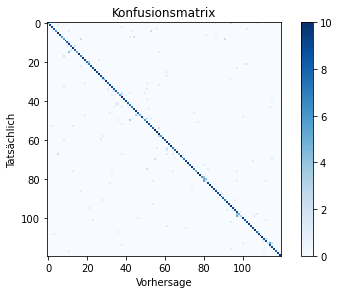

In [12]:
plot_cm(test_batches.classes, preds)